In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import gymnasium as gym

%reload_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('/home/hurra/Projects/survey-ops/')


In [19]:
import survey_ops
from survey_ops.utils import units, geometry, interpolate
from survey_ops.src.environments import *
from survey_ops.src.offline_dataset import TelescopeDatasetv0
from survey_ops.src.agents import Agent
from survey_ops.src.algorithms import DDQN, BehaviorCloning
from survey_ops.utils.pytorch_utils import seed_everything


In [20]:
# import pickle
# import time
# import sys
# sys.path.append('../survey_ops/utils')
# import ephemerides
# import geometry
# import units
# sys.path.append('../survey_ops/src')
# import environments
# from offline_dataset import TelescopeDatasetv0
# from agents import Agent
# from algorithms import DDQN, BehaviorCloning

In [21]:
from pytorch_utils import seed_everything

# Load Data

In [22]:
import json
with open("../data/2013-09-15_gband_fields.json") as f:
    old_id2pos = json.load(f)

In [23]:
id2pos = {}
for key in old_id2pos.keys():
    id2pos[int(key)] = old_id2pos[key]

In [24]:
import pandas as pd
schedule = pd.read_csv('../data/2013-09-15_gband_schedule.csv', dtype={'next_field':'Int64'})

In [25]:
schedule_old = schedule.copy()

In [26]:
schedule_old

,time,field_id,next_field
0,1379248382,44,23
1,1379248544,23,53
2,1379248664,53,11
3,1379248794,11,16
4,1379248913,16,20
5,1379249032,20,54
6,1379249156,54,57
7,1379249275,57,33
8,1379249398,33,19
9,1379249529,19,9


In [27]:
field_id = 10
timestamp = schedule.iloc[field_id].time
field_ra, field_dec = id2pos[field_id]
field_az, field_el = ephemerides.equatorial_to_topographic(field_ra, field_dec, time=timestamp)
sun_ra, sun_dec = ephemerides.get_source_ra_dec("sun", time=timestamp)
sun_az, sun_el = ephemerides.equatorial_to_topographic(sun_ra, sun_dec, time=timestamp)
moon_ra, moon_dec = ephemerides.get_source_ra_dec("moon", time=timestamp)
moon_az, moon_el = ephemerides.equatorial_to_topographic(moon_ra, moon_dec, time=timestamp)

In [28]:
schedule.time

0     1379248382
1     1379248544
2     1379248664
3     1379248794
4     1379248913
5     1379249032
6     1379249156
7     1379249275
8     1379249398
9     1379249529
10    1379249655
11    1379249776
12    1379249894
13    1379250022
14    1379250146
15    1379250265
16    1379250385
17    1379250508
18    1379250625
19    1379250745
20    1379250873
21    1379250995
22    1379251113
23    1379251233
24    1379251365
25    1379251486
26    1379251606
27    1379251734
28    1379251865
29    1379251987
30    1379252114
31    1379252234
32    1379252355
33    1379252499
34    1379252624
35    1379252755
36    1379252874
37    1379252993
38    1379253125
39    1379253246
40    1379253371
41    1379253498
42    1379253618
43    1379253745
44    1379253870
45    1379253996
46    1379254115
47    1379254248
48    1379254367
49    1379254487
50    1379254607
51    1379254733
52    1379254855
53    1379254983
54    1379255103
55    1379255225
56    1379255345
57    1379255473
58    13792556

# Visualize schedule

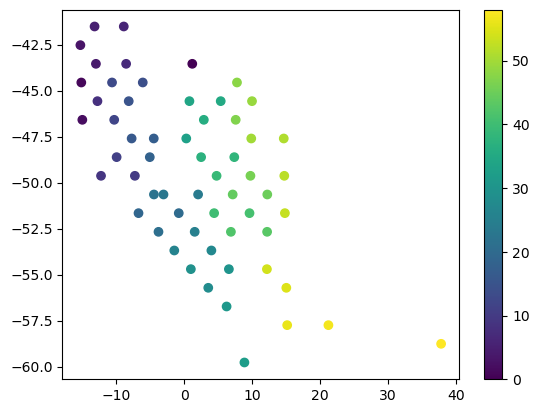

In [29]:

radec = np.array([id2pos[field_id] for field_id in schedule.field_id.values])
ra_shifted = np.where(radec[:, 0] > 180, radec[:, 0] - 360, radec[:, 0])
c = plt.scatter(ra_shifted, radec[:, 1], c = np.arange(len(ra_shifted)))
plt.colorbar(c)

# Configure dataset, model, and training setup

In [30]:
SEED = 10
train_size = 1


seed_everything(SEED)

torch.set_default_dtype(torch.float32)

device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "cpu"   
)

In [31]:
dataset = TelescopeDatasetv0(schedule, id2pos, normalize_obs=True)

In [34]:
"""DESIRED Algorithm and Train setup"""

alg_config = {
    'obs_dim': dataset.obs_dim,
    'num_actions': dataset.num_actions,
    'hidden_dim': 64,
    'device': device,
    'lr': 1e-3,
    'loss_fxn': None, #torch.nn.cross_entropy,
    # 'use_double': True,
}
alg = BehaviorCloning(**alg_config)

fit_config = {
    'num_epochs' : 3000,
    'batch_size': 32,
    # 'learning_start': 
    }

env_name = 'TelescopeEnv-v0'

def create_exp_name(alg, env_name, dataset, fit_config, alg_config):

    exp_name = f"{alg.name}"
    exp_name += f"-{env_name}"
    exp_name += f"-n_unique={dataset._nfields}"
    # config_prefix += f"-use_double={alg_config['use_double']}"
    exp_name += f"-num_epochs={fit_config['num_epochs']}"
    exp_name += f"-batch_size={fit_config['batch_size']}"
    exp_name += f"-lr={alg_config['lr']}"

exp_name = create_exp_name(alg, env_name, dataset, fit_config, alg_config)

outdir = f'../results/{exp_name}/'
if not os.path.exists(outdir):
    os.makedirs(outdir)
fig_outdir = outdir + 'figures/'
if not os.path.exists(fig_outdir):
    os.makedirs(fig_outdir)


agent_config = {
    'algorithm': alg,
    'normalize_obs': dataset.normalize_obs,
    'outdir': outdir
    }

agent = Agent(**agent_config)



In [35]:
from environments import TelescopeEnv_v0

env_name = 'TelescopeEnv-v0'

gym.register(
    id=f"gymnasium_env/{env_name}",
    entry_point=TelescopeEnv_v0,
    max_episode_steps=300,  # Prevent infinite episodes. Here just set to 300 even though episode will terminate when stepping to last element of sequence
)

# for eval step only
env_config = {
    'id': f"gymnasium_env/{env_name}",
    'dataset': dataset
}


env = gym.make(**env_config)
# Create multiple environments for parallel training
# vec_env = gym.make_vec("gymnasium_env/SimpleTel-v0", num_envs=5, vectorization_mode='sync', Nf=Nf, target_sequence=true_sequence, nv_max=nv_max)

from gymnasium.utils.env_checker import check_env

# This will catch many common issues
try:
    check_env(env.unwrapped)
    print("Environment passes all checks!")
except Exception as e:
    print(f"Environment has issues: {e}")

Environment passes all checks!


# Train

In [37]:
start_time = time.time()
"""Train"""
agent.fit(
    dataset=dataset,
    **fit_config
    )
end_time = time.time()
train_time = end_time - start_time
print(train_time)

  8%|███                                   | 445/5437 [00:00<00:02, 1719.39it/s]

Train step 0: Accuracy = 0.031, Loss = 4.0660
Train step 100: Accuracy = 0.094, Loss = 3.6914
Train step 200: Accuracy = 0.219, Loss = 2.8512
Train step 300: Accuracy = 0.375, Loss = 2.3099
Train step 400: Accuracy = 0.500, Loss = 1.8885


 16%|██████▏                               | 886/5437 [00:00<00:02, 2014.89it/s]

Train step 500: Accuracy = 0.500, Loss = 1.5611
Train step 600: Accuracy = 0.625, Loss = 1.3110
Train step 700: Accuracy = 0.750, Loss = 1.2328
Train step 800: Accuracy = 0.750, Loss = 1.0180
Train step 900: Accuracy = 0.844, Loss = 0.6508


 24%|█████████                            | 1326/5437 [00:00<00:01, 2117.62it/s]

Train step 1000: Accuracy = 0.812, Loss = 0.7933
Train step 1100: Accuracy = 0.719, Loss = 0.6164
Train step 1200: Accuracy = 0.938, Loss = 0.5856
Train step 1300: Accuracy = 0.781, Loss = 0.5165
Train step 1400: Accuracy = 0.781, Loss = 0.5108


 33%|████████████                         | 1780/5437 [00:00<00:01, 2203.30it/s]

Train step 1500: Accuracy = 0.906, Loss = 0.3912
Train step 1600: Accuracy = 0.906, Loss = 0.4357
Train step 1700: Accuracy = 1.000, Loss = 0.4217
Train step 1800: Accuracy = 0.875, Loss = 0.3772
Train step 1900: Accuracy = 0.938, Loss = 0.2898


 41%|███████████████                      | 2222/5437 [00:01<00:01, 2190.88it/s]

Train step 2000: Accuracy = 1.000, Loss = 0.2460
Train step 2100: Accuracy = 0.906, Loss = 0.2296
Train step 2200: Accuracy = 0.969, Loss = 0.3349
Train step 2300: Accuracy = 0.969, Loss = 0.2324
Train step 2400: Accuracy = 0.938, Loss = 0.2305


 53%|███████████████████▋                 | 2885/5437 [00:01<00:01, 2194.87it/s]

Train step 2500: Accuracy = 1.000, Loss = 0.1979
Train step 2600: Accuracy = 1.000, Loss = 0.2599
Train step 2700: Accuracy = 1.000, Loss = 0.1913
Train step 2800: Accuracy = 0.938, Loss = 0.2673
Train step 2900: Accuracy = 1.000, Loss = 0.1418


 61%|██████████████████████▋              | 3325/5437 [00:01<00:00, 2190.67it/s]

Train step 3000: Accuracy = 1.000, Loss = 0.1137
Train step 3100: Accuracy = 0.969, Loss = 0.1305
Train step 3200: Accuracy = 1.000, Loss = 0.0982
Train step 3300: Accuracy = 1.000, Loss = 0.1308
Train step 3400: Accuracy = 1.000, Loss = 0.0314


 70%|██████████████████████████           | 3821/5437 [00:01<00:00, 2283.73it/s]

Train step 3500: Accuracy = 1.000, Loss = 0.2317
Train step 3600: Accuracy = 1.000, Loss = 0.0814
Train step 3700: Accuracy = 1.000, Loss = 0.1293
Train step 3800: Accuracy = 1.000, Loss = 0.0706
Train step 3900: Accuracy = 1.000, Loss = 0.1103


 79%|█████████████████████████████▎       | 4306/5437 [00:02<00:00, 2341.88it/s]

Train step 4000: Accuracy = 1.000, Loss = 0.0799
Train step 4100: Accuracy = 1.000, Loss = 0.1206
Train step 4200: Accuracy = 1.000, Loss = 0.0897
Train step 4300: Accuracy = 1.000, Loss = 0.1191
Train step 4400: Accuracy = 1.000, Loss = 0.0580
Train step 4500: Accuracy = 0.969, Loss = 0.0395


 94%|██████████████████████████████████▋  | 5099/5437 [00:02<00:00, 2539.04it/s]

Train step 4600: Accuracy = 1.000, Loss = 0.0728
Train step 4700: Accuracy = 1.000, Loss = 0.0489
Train step 4800: Accuracy = 1.000, Loss = 0.0299
Train step 4900: Accuracy = 1.000, Loss = 0.0320
Train step 5000: Accuracy = 1.000, Loss = 0.0409
Train step 5100: Accuracy = 1.000, Loss = 0.0267


100%|█████████████████████████████████████| 5437/5437 [00:02<00:00, 2208.34it/s]

Train step 5200: Accuracy = 1.000, Loss = 0.0624
Train step 5300: Accuracy = 1.000, Loss = 0.0295
Train step 5400: Accuracy = 1.000, Loss = 0.0467
2.464930534362793


In [38]:
with open(outdir + 'train_metrics.pkl', 'rb') as handle:
    train_metrics = pickle.load(handle)

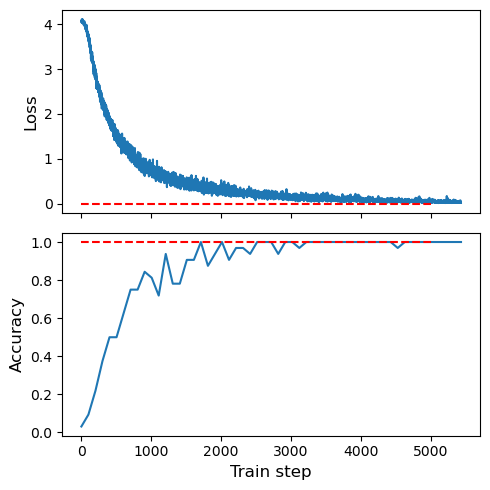

In [39]:
fig, axs = plt.subplots(2, sharex=True, figsize=(5, 5))
axs[0].plot(train_metrics['loss_history'])
axs[0].hlines(y=0, xmin=0, xmax=5000, color='red', linestyle='--')
axs[0].set_ylabel('Loss', fontsize=12)
axs[1].plot(np.linspace(0, len(train_metrics['loss_history']), len(train_metrics['test_acc_history'])), train_metrics['test_acc_history'])
axs[1].hlines(y=1, xmin=0, xmax=5000, color='red', linestyle='--')
axs[1].set_xlabel('Train step', fontsize=12)
axs[1].set_ylabel('Accuracy', fontsize=12)
axs[1].set_xlabel('Train step', fontsize=12)
fig.tight_layout()
fig.savefig(fig_outdir + 'train_history.png')

# Evaluate

In [40]:
agent.evaluate(env=env, num_episodes=1)
with open(outdir + 'eval_metrics.pkl', 'rb') as handle:
    eval_metrics = pickle.load(handle)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]

terminated at 58
eval_metrics.pkl saved in ../results/None/


/tmp/ipykernel_62739/76053858.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend()


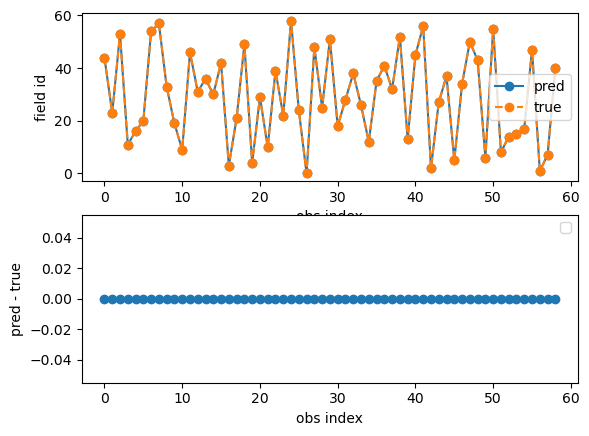

In [41]:
target_sequence = dataset._schedule_field_ids[0]
eval_sequence = eval_metrics['observations']['ep-0'][:, 0]

fig, axs = plt.subplots(2)
axs[0].plot(eval_sequence, marker='o', label='pred')
axs[0].plot(target_sequence, marker='o', linestyle='dashed', label='true')
axs[0].legend()
axs[0].set_xlabel('obs index')
axs[0].set_ylabel('field id')

axs[1].plot(eval_sequence - target_sequence, marker='o')
axs[1].legend()
axs[1].set_xlabel('obs index')
axs[1].set_ylabel('pred - true')


fig.savefig(outdir + 'learned_sequence.png')

In [45]:
with torch.no_grad():
    obs, expert_actions, rewards, next_obs, dones, action_masks = dataset.sample(25)
    action_logits = agent.algorithm.policy_net(torch.tensor(obs, device=device))
    action = torch.argmax(action_logits, dim=1)